In [1]:

import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


data = pd.read_excel('weather.nominal.xlsx')
data = pd.DataFrame(data[0:])
df=data
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   outlook      14 non-null     object
 1   temperature  14 non-null     object
 2   humidity     14 non-null     object
 3   windy        14 non-null     bool  
 4   play         14 non-null     object
dtypes: bool(1), object(4)
memory usage: 590.0+ bytes


# Data cleaning

In [2]:
def assess_NA(data):
  
    # pandas series denoting features and the sum of their null values
    null_sum = data.isnull().sum()# instantiate columns for missing data
    total = null_sum.sort_values(ascending=False)
    percent = ( ((null_sum / len(data.index))*100).round(2) ).sort_values(ascending=False)
    
    # concatenate along the columns to create the complete dataframe
    df_NA = pd.concat([total, percent], axis=1, keys=['Number of NA', 'Percent NA'])
    
    # drop rows that don't have any missing data; omit if you want to keep all rows
    df_NA = df_NA[ (df_NA.T != 0).any() ]
    
    return df_NA


df_NA=assess_NA(df)   
df_NA 


df = df.dropna(axis=0)



# Chi-square Test of Independence
The chi-square test of independence is used to determine whether there is an association between two or more categorical variables.

This can be easily done in Python using the chi2_contingency() function from the scipy.stats module. The lines of code below perform the test.

,outlook,temperature,humidity,windy,play
outlook,0.000000,3.325000,0.400000,0.116667,3.546667
temperature,3.325000,0.000000,5.666667,0.729167,0.570370
humidity,0.400000,5.666667,0.000000,0.000000,1.244444
windy,0.116667,0.729167,0.000000,0.000000,0.162037
play,3.546667,0.570370,1.244444,0.162037,0.000000


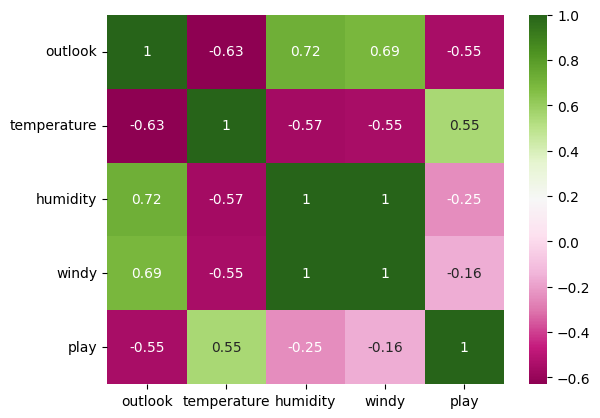

In [3]:
#Correlation between categorical variable: Turns out, the only solution I found is to iterate trough all the factor*factor pairs.

from scipy.stats import chi2_contingency
factors_paired = [(i,j) for i in df.columns.values for j in df.columns.values] 

chi2, p_values =[], []

for f in factors_paired:
    if f[0] != f[1]:
        chitest = chi2_contingency(pd.crosstab(df[f[0]], df[f[1]]))   
        chi2.append(chitest[0])
        p_values.append(chitest[1])
    else:      # for same factor pair
        chi2.append(0)
        p_values.append(0)

chi2 = np.array(chi2).reshape((5,5)) # shape it as a matrix
chi2 = pd.DataFrame(chi2, index=df.columns.values, columns=df.columns.values) # then a df for convenience
chi2.corr(method='pearson', min_periods=1)

fig = plt.figure()
sns.heatmap(chi2.corr(), cmap="PiYG", annot=True)
chi2

As you can see in the heatmap, some of the features in the dataset are highly correlated with each other. 

So, there exists multicollinearity
if we take play as a target we could primarily conclude and figure out that windy is the lowest correlated var so the lowest impact 


# categorical variable encoding

In [4]:

X = df[["windy","outlook","temperature","humidity"]]
y = df["play"]
X = pd.get_dummies(data=X, drop_first=True)
y = pd.get_dummies(data=y, drop_first=True)

X


,windy,outlook_rainy,outlook_sunny,temperature_hot,temperature_mild,humidity_normal
0,False,0,1,1,0,0
1,True,0,1,1,0,0
2,False,0,0,1,0,0
3,False,1,0,0,1,0
4,False,1,0,0,0,1
5,True,1,0,0,0,1
6,True,0,0,0,0,1
7,False,0,1,0,1,0
8,False,0,1,0,0,1
9,False,1,0,0,1,1


 # pca
 To apply PCA on this data-set, first we scale all the features and then apply fit_transformmethod of PCA
(with 6 principal components) on the scaled features.

We show that 2 contribute to 70% of the total variance.
Based on these 2 principal components we visualize the data and see very clear separation between ‘we play’ and ‘do not play’ classes.


Eigenvalues:
[2.2909268  1.46612583 1.15781956 0.93817384 0.39766586 0.21082656]

Variances (Percentage):
[35.45481958 22.69004263 17.91863603 14.51935705  6.15435266  3.26279204]



Text(0, 0.5, 'Explained variance (%)')

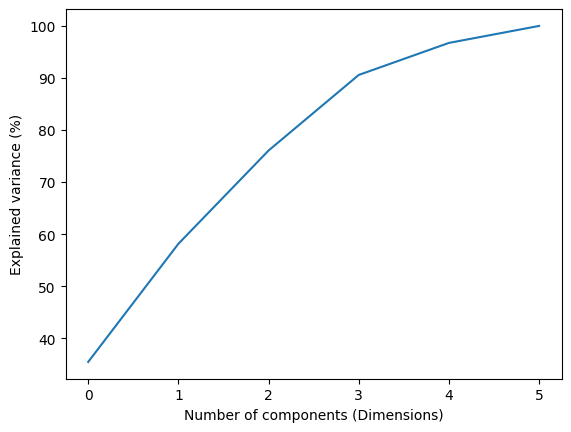

In [6]:

#PCA to reduce the dimension:
# Do feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
pca.fit(X_scaled)

# Get the eigenvalues
print("Eigenvalues:")
print(pca.explained_variance_)
print()

# Get explained variances
print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)
print()

# Make the scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")


In [7]:

# Do feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(X_scaled)

# Get the transformed dataset
X_pca = pd.DataFrame(x_pca, columns =
 ['principal component 1', 'principal component 2'])
# print(X_pca)
# print("\nSize: ")
# print(X_pca.shape)


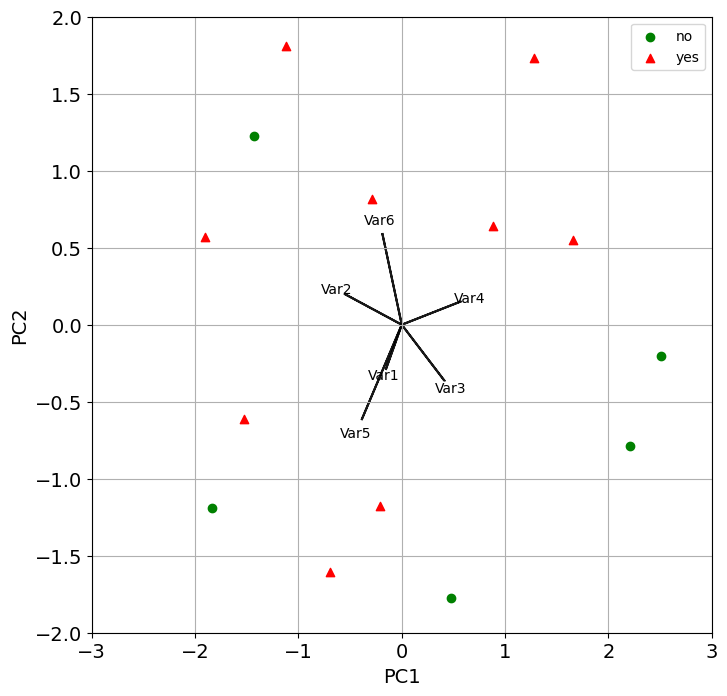

In [51]:
def biplot(score, coeff , target):
    '''
       score: the projected data
       coeff: the eigenvectors (PCs)
       target: the class labels
   '''
    xs = score[:,0] # projection on PC1
    ys = score[:,1] # projection on PC2
    n = coeff.shape[0] # number of variables
    plt.figure(figsize=(8,8), dpi=100)
    classes = np.unique(target)
    colors = ['g','r','target']
    markers=['o','^','x']
    for s,l in enumerate(classes):
        plt.scatter(xs[target==l],ys[target==l], c = colors[s], marker=markers[s]) # color based on group
        plt.legend(classes)
    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'k', alpha = 0.9,linestyle = '-',linewidth = 1.5, overhang=0.2)
        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center',fontsize=10)

    plt.xlabel("PC{}".format(1), size=14)
    plt.ylabel("PC{}".format(2), size=14)
    limx= int(xs.max()) + 1
    limy= int(ys.max()) + 1
    plt.xlim([-limx,limx])
    plt.ylim([-limy,limy])
    plt.grid()
    
    plt.tick_params(axis='both', which='both', labelsize=14)

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault) # reset ggplot style
# Call the biplot function for only the first 2 PCs
biplot(x_pca[:,0:2], np.transpose(pca.components_[0:2, :]),df["play"])
plt.show()

corr = pca.components_
features = pca.explained_variance_ratio_
matrix = pca.components_.T * np.sqrt(pca.explained_variance_)
print(matrix,"\n\n",features,"\n\n",(corr),"\n")

# print(np.cov(X_pca.T))#==pca.explained_variance_



 we apply PCA to exactly see how well PCA captures the variance of our data.
 
feature 2 and 4 are the most important for PC1. 
Similarly, feature 5 and then 6 are the most important for PC2.

Here, pca.components_ has shape [n_components, n_features]
Furthermore, arrows (variables/features)

 that point into the same direction
 indicate correlation between the variables that they represent whereas,
 
Tthe arrows heading in opposite directions indicate a contrast between the variables they represent.

The larger they are these absolute values, the more a specific feature contributes to that principal component.

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4984\3293720805.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


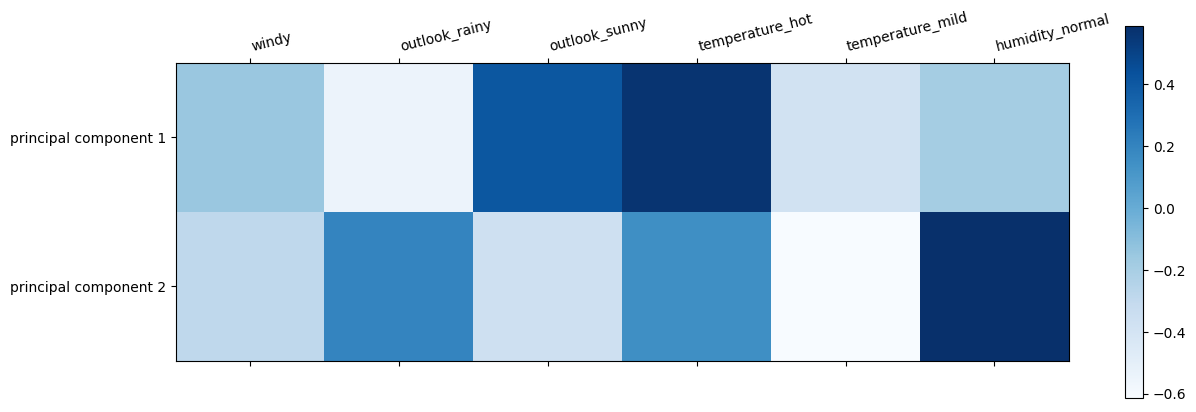

<AxesSubplot: >

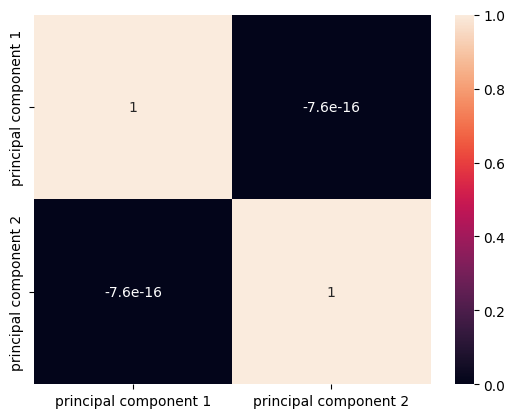

In [16]:
plt.matshow(pca.components_,cmap='Blues')
plt.yticks([0,1],
['principal component 1', 'principal component 2'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(X.columns)),X,rotation=14,ha='left')
plt.tight_layout()
plt.show() 
sns.heatmap(X_pca.corr(),annot=True)


We cannot see any correlation between components. This is because PCA has transformed the set of correlated variables in the original dataset into a set of uncorrelated variables.

# He will play or no?
# logistic regression model


In [54]:


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    shuffle=True, random_state=2)

# Initialize the logistic regression model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=2500)

# get the start datetime
st = datetime.datetime.now()

# Train the model
clf.fit(X_train, y_train)

# Make predictions

y_pred = clf.predict(X_test) # Predictions
y_true = y_test # True values
print("***** without pca : we predict the test dataset which in our exemple equal 3 rows *****")
print(y_pred)
print(y_true)
print("**************************************************************************************")

# get the end datetime
ed = datetime.datetime.now()
# get execution time
elapsed_time = ed - st
print('Execution time:', elapsed_time, 'seconds')


# Measure accuracy
from sklearn.metrics import accuracy_score
import numpy as np
print("Train accuracy:", np.round(accuracy_score(y_train, 
                                                 clf.predict(X_train)), 2))
print("Test accuracy:", np.round(accuracy_score(y_true, y_pred), 2))

# Make the confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print("\nTest confusion_matrix")
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
cf_matrix


C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


***** without pca : we predict the test dataset which in our exemple equal 3 rows *****
[1 1 1]
    yes
11    1
4     1
5     0
**************************************************************************************
Execution time: 0:00:00.085110 seconds
Train accuracy: 0.91
Test accuracy: 0.67

Test confusion_matrix


array([[0, 1],
       [0, 2]], dtype=int64)

In [55]:
#prediction ex 
exemple=pd.DataFrame([0,0,0,0,0,0])
exemple = pd.get_dummies(data=exemple, drop_first=True)
exemple = sc.fit_transform(exemple)
new_predictions = clf.predict(exemple.reshape(1,-1))
print(new_predictions)

[1]


C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


# logistic regression with pca
notice that pca will reduce the execution time

In [56]:


# logistic regression with pca and solver lbfgs
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    shuffle=True, random_state=2)
# Initialize the logistic regression model
from sklearn.linear_model import LogisticRegression
sc.fit(X_train)
X_train= sc.transform(X_train)
X_test = sc.transform(X_test)
pca = PCA(.85)
pca.fit(X_train)
X_train= pca.transform(X_train)
X_test = pca.transform(X_test)

logisticRegr = LogisticRegression(solver = 'lbfgs')


# get the start datetime
st = datetime.datetime.now()

logisticRegr.fit(X_train, y_train)
logisticRegr.score(X_test, y_test)

y_pred = logisticRegr.predict(X_test) # Predictions
y_true = y_test
print(y_pred)
print(y_true)


# get the end datetime
et = datetime.datetime.now()
# get execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

# from sklearn.metrics import accuracy_score
# import numpy as np
# print("Train accuracy:", np.round(accuracy_score(y_train, 
#                                                  logisticRegr.predict(X_train)), 2))
# print("Test accuracy:", np.round(accuracy_score(y_true, y_pred), 2))



[0 1 1]
    yes
11    1
4     1
5     0
Execution time: 0:00:00.009463 seconds


C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


After applying pca we can conclude the the feature windy has the low impact so we will ignore it

In [10]:


data_apriori = pd.read_excel('weather.nominal.xlsx',header=None)
data_apriori = pd.DataFrame(data_apriori[1:])
data_apriori.drop(data_apriori.columns[3], axis=1, inplace=True)
items= data_apriori.values.tolist()


te = TransactionEncoder()
data_transformed = te.fit_transform(items)
d= pd.DataFrame(data_transformed, columns=te.columns_)
d

,cool,high,hot,mild,no,normal,overcast,rainy,sunny,yes
0,False,True,True,False,True,False,False,False,True,False
1,False,True,True,False,True,False,False,False,True,False
2,False,True,True,False,False,False,True,False,False,True
3,False,True,False,True,False,False,False,True,False,True
4,True,False,False,False,False,True,False,True,False,True
5,True,False,False,False,True,True,False,True,False,False
6,True,False,False,False,False,True,True,False,False,True
7,False,True,False,True,True,False,False,False,True,False
8,True,False,False,False,False,True,False,False,True,True
9,False,False,False,True,False,True,False,True,False,True


we took the minimum possible support  0,01 then we try to remove the outliers possibilities  next we extract the minimum frequent value of our items support

0.071

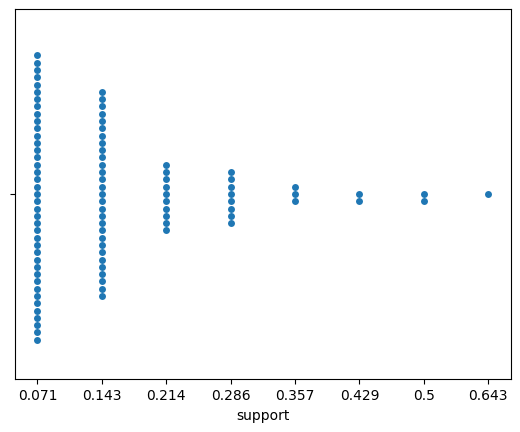

In [11]:

frequent_items = apriori(d, min_support=0.01, use_colnames=True)
frequent_items["support"]=(frequent_items["support"].round(decimals=3))
frequent_items = frequent_items.sort_values(by = 'support')
%matplotlib inline
sns.swarmplot(x="support",data=frequent_items.astype("unicode"))
def remove_outliers(d,columns,n_std):
    for col in columns:
        # print('Working on column: {}'.format(col))
        mean = d[col].mean()
        sd = d[col].std()
        d = d[(d[col] <= mean+(n_std*sd))]
    return d
frequent_items_final=remove_outliers(frequent_items,columns=["support"],n_std=3)
new_val=frequent_items_final.describe()["support"]["min"]
frequent_items_final = apriori(d, min_support=new_val, use_colnames=True)
new_val

In [12]:

rules = association_rules(frequent_items_final, metric ="confidence")
rules = rules.sort_values(by=['confidence', 'lift','support'], ascending =False).reset_index(drop=True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(no, normal)","(cool, rainy)",0.071429,0.142857,0.071429,1.000000,7.000000,0.061224,inf
1,"(no, hot)","(sunny, high)",0.142857,0.214286,0.142857,1.000000,4.666667,0.112245,inf
2,"(no, cool)","(normal, rainy)",0.071429,0.214286,0.071429,1.000000,4.666667,0.056122,inf
3,"(mild, overcast)","(yes, high)",0.071429,0.214286,0.071429,1.000000,4.666667,0.056122,inf
4,"(yes, hot)",(overcast),0.142857,0.285714,0.142857,1.000000,3.500000,0.102041,inf
5,"(hot, sunny)","(no, high)",0.142857,0.285714,0.142857,1.000000,3.500000,0.102041,inf
6,"(no, normal)",(cool),0.071429,0.285714,0.071429,1.000000,3.500000,0.051020,inf
7,"(normal, hot)",(overcast),0.071429,0.285714,0.071429,1.000000,3.500000,0.051020,inf
8,"(no, normal, rainy)",(cool),0.071429,0.285714,0.071429,1.000000,3.500000,0.051020,inf
9,"(yes, hot, high)",(overcast),0.071429,0.285714,0.071429,1.000000,3.500000,0.051020,inf


we will create a function that returns the items which are likely to be appear by user as an output
because he appear the item passed into function
we will give it a try by passing cool as a parameter

In [13]:

def frequently_appear_t(item):
    # df of item passed
    item_d = d.loc[d[item]==1]
    # Applying apriori algorithm on item df
    frequentitemsets = apriori(item_d, min_support=new_val, use_colnames=True)
    # Storing association rules
    rules = association_rules(frequentitemsets, metric="confidence")#metric="lift", min_threshold=1
    # Sorting on lift and support
    rules.sort_values(['confidence','lift','support'],ascending=False).reset_index(drop=True)
    print('Items frequently appear together with {0}'.format(item))
    # Returning top 6 items with highest lift and support
    return rules['consequents'].unique()#[:6]


frequently_appear_t("cool")

Items frequently appear together with cool


array([frozenset({'cool'}), frozenset({'normal'}), frozenset({'rainy'}),
       frozenset({'yes'}), frozenset({'cool', 'normal'}),
       frozenset({'cool', 'rainy'}), frozenset({'cool', 'yes'}),
       frozenset({'normal', 'rainy'}), frozenset({'normal', 'yes'}),
       frozenset({'cool', 'normal', 'rainy'}),
       frozenset({'cool', 'normal', 'yes'})], dtype=object)

# Isolation Forests – an unsupervised anomaly detection technique - select the outliers in all posssible items antecedent 


https://www.lovelyanalytics.com/2020/06/25/isolation-forest-comment-ca-marche/#:~:text=Isolation%20Forest%20%28for%C3%AAt%20d%E2%80%99isolation%29%20est%20un%20algorithme%20de,d%C3%A9tection%20de%20fraude%20en%20identifiant%20des%20cas%20atypiques.

Forêts d'isolement
Les forêts d'isolement (IF), similaires aux forêts aléatoires, sont construites sur la base d'arbres de décision. Et comme il n'y a pas d'étiquettes prédéfinies ici, il s'agit d'un modèle non supervisé.

Les IsolationForests ont été construites sur la base du fait que les anomalies sont les points de données qui sont "peu nombreux et différents".

Regardons pas à pas l'algorithme complet :

Lorsqu'on leur donne un ensemble de données, un sous-échantillon aléatoire des données est sélectionné et affecté à un arbre binaire.

When given a dataset, a random sub-sample of the data is selected and assigned to a binary tree.

Branching of the tree starts by selecting a random feature (from the set of all N features) first. And then branching is done on a random threshold ( any value in the range of minimum and maximum values of the selected feature).

If the value of a data point is less than the selected threshold, it goes to the left branch else to the right. And thus a node is split into left and right branches.

This process from step 2 is continued recursively till each data point is completely isolated or till max depth(if defined) is reached.

The above steps are repeated to construct random binary trees.

Now, an ‘anomaly score’ is assigned to each of the data points based on the depth of the tree required to arrive at that point
This score is an aggregation of the depth obtained from each of the iTrees. An anomaly score of -1 is assigned to anomalies and 1 to normal points based on the contamination(percentage of anomalies present in the data) parameter provided.

# Isolation Forests – an unsupervised anomaly detection technique
# - select the outliers in all posssible items antecedent 


In [14]:
rules = association_rules(frequent_items,min_threshold=0.01)
rules = rules.sort_values(by=['confidence', 'lift'], ascending =False)
rules=pd.DataFrame(rules)
# rules=pd.DataFrame(rules[["antecedents","consequents"]])
# rules.describe()
rules["antecedents"]=(rules["antecedents"].astype('unicode'))
rules["antecedents"] = rules["antecedents"].str.removeprefix("frozenset({'")
rules["antecedents"]= rules["antecedents"].str.removesuffix("'})")
rules["antecedents"]=rules["antecedents"].replace(regex=["\', \'"], value=' ')

rules["consequents"]=(rules["consequents"].astype('unicode'))
rules["consequents"] = rules["consequents"].str.removeprefix("frozenset({'")
rules["consequents"]= rules["consequents"].str.removesuffix("'})")
rules["consequents"]=rules["consequents"].replace(regex=["\', \'"], value=' ')

#categorical transformation 
r=rules.iloc[:,2:3].values # combinaison rare
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import IsolationForest
ct=ColumnTransformer(transformers=[('encoder',OneHotEncoder(),[0])],remainder='drop')
r=ct.fit_transform(r)
model=IsolationForest()

model.fit(r)
rules['score']=model.decision_function(r)
rules['anomaly']=model.predict(r)
rules.sort_values(by=['score'], ascending =False).reset_index(drop=True)




,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,score,anomaly
0,overcast,mild,0.286,0.429,0.071,0.248252,0.578675,-0.051694,0.759563,0.041788,1
1,mild yes,high,0.286,0.500,0.143,0.500000,1.000000,0.000000,1.000000,0.041788,1
2,yes overcast,mild,0.286,0.429,0.071,0.248252,0.578675,-0.051694,0.759563,0.041788,1
3,overcast,normal,0.286,0.500,0.143,0.500000,1.000000,0.000000,1.000000,0.041788,1
4,mild high,yes,0.286,0.643,0.143,0.500000,0.777605,-0.040898,0.714000,0.041788,1
5,hot,yes,0.286,0.643,0.143,0.500000,0.777605,-0.040898,0.714000,0.041788,1
6,cool,yes,0.286,0.643,0.214,0.748252,1.163689,0.030102,1.418083,0.041788,1
7,cool normal,yes,0.286,0.643,0.214,0.748252,1.163689,0.030102,1.418083,0.041788,1
8,hot,high,0.286,0.500,0.214,0.748252,1.496503,0.071000,1.986111,0.041788,1
9,cool,normal yes,0.286,0.429,0.214,0.748252,1.744177,0.091306,2.268139,0.041788,1


In [63]:
rules_anomal=rules[['antecedents','score']]
rules_anomal['antecedents'].describe()
rules_anomal=rules_anomal.drop_duplicates()

# rules_anomal.sort_values(by=['score'], ascending =False).reset_index(drop=True)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_4984\4182422880.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(rules_anomal["antecedents"],rotation=90)


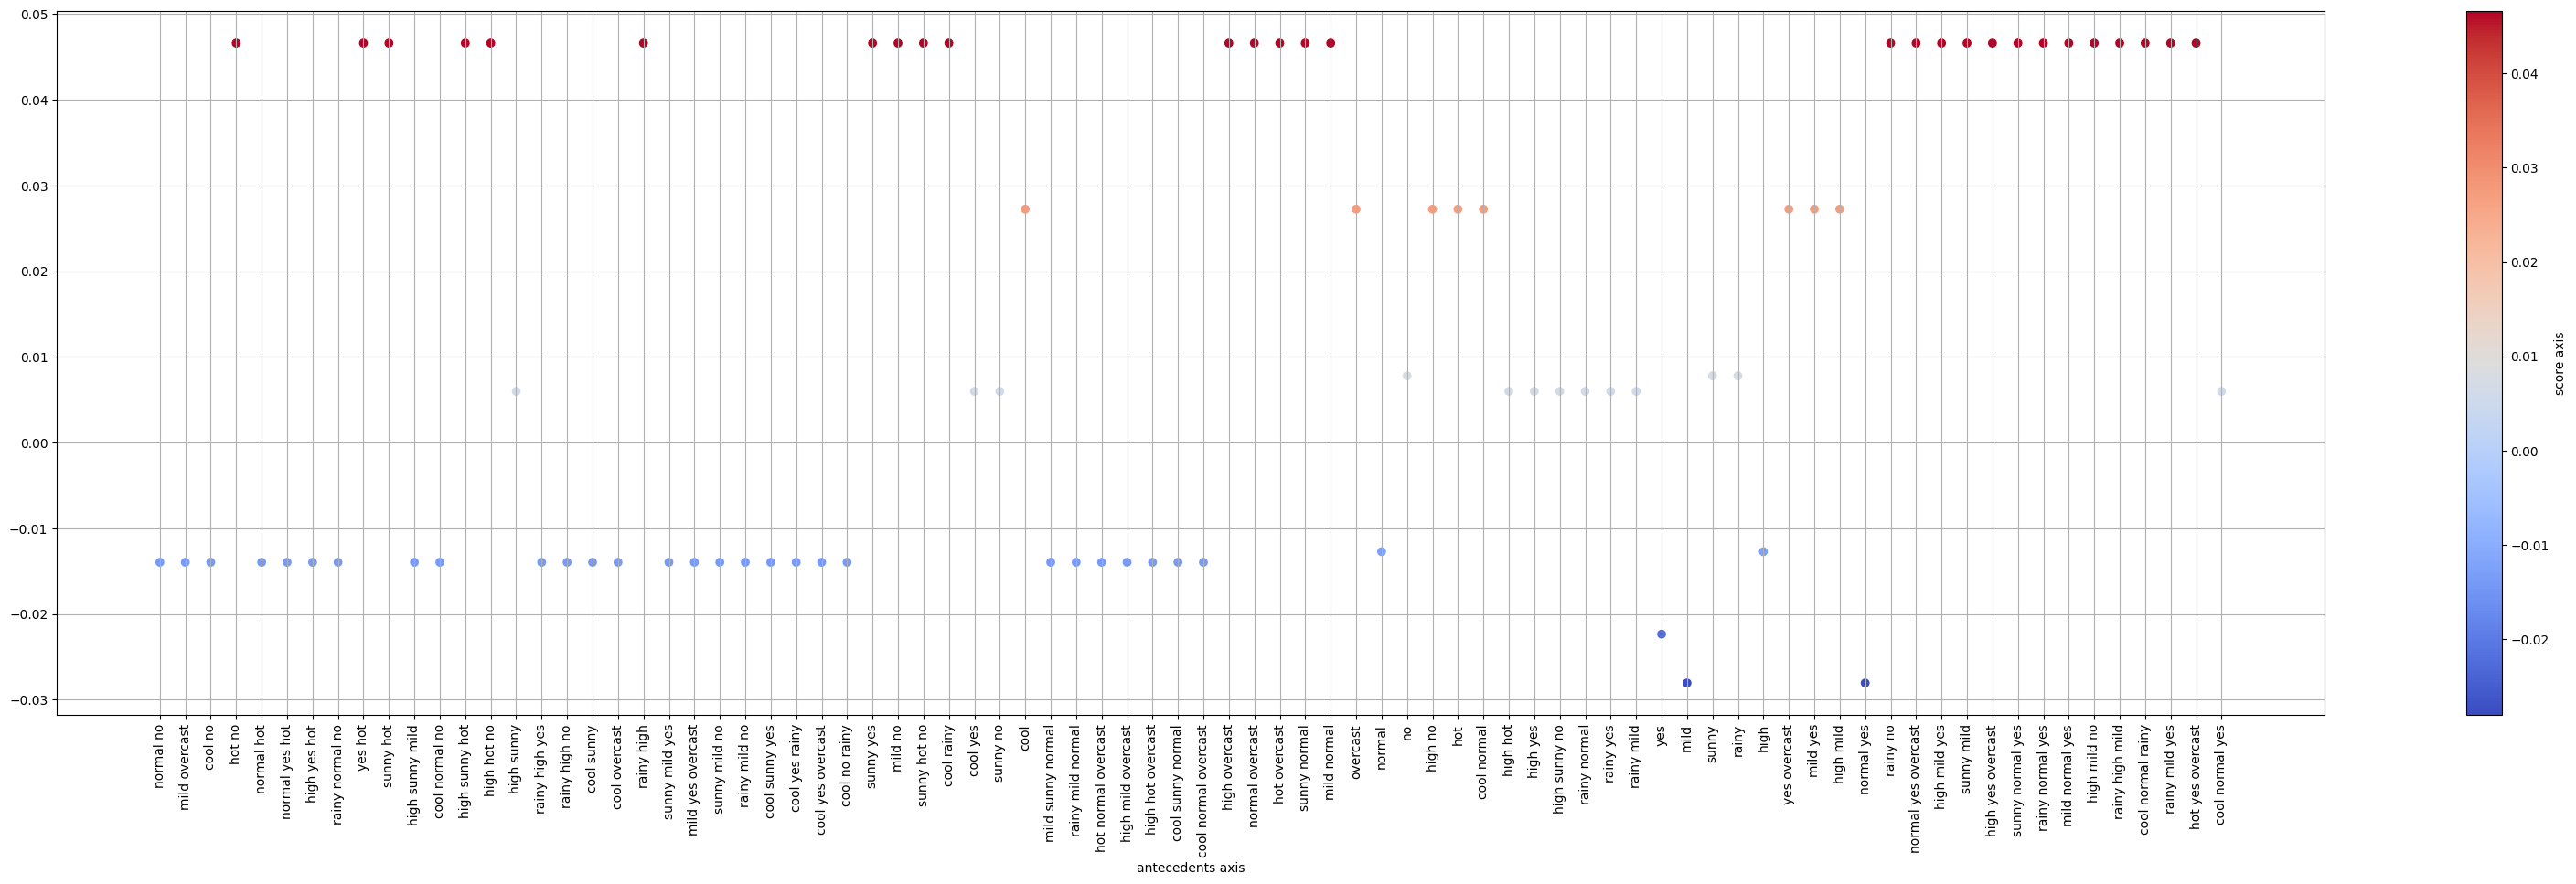

In [64]:
%matplotlib inline

c = (rules_anomal["score"].values)
fig, ax = plt.subplots(figsize=(40,10))
f = ax.scatter(x=rules_anomal["antecedents"],y=rules_anomal["score"], c=c, cmap='coolwarm')
cbar = plt.colorbar(f)

ax.set_xlabel('antecedents axis')
ax.set_xticklabels(rules_anomal["antecedents"],rotation=90)
cbar.set_label('score axis', rotation=90)
ax.grid()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4984\3032579745.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(rules2["antecedents"],rotation=90)


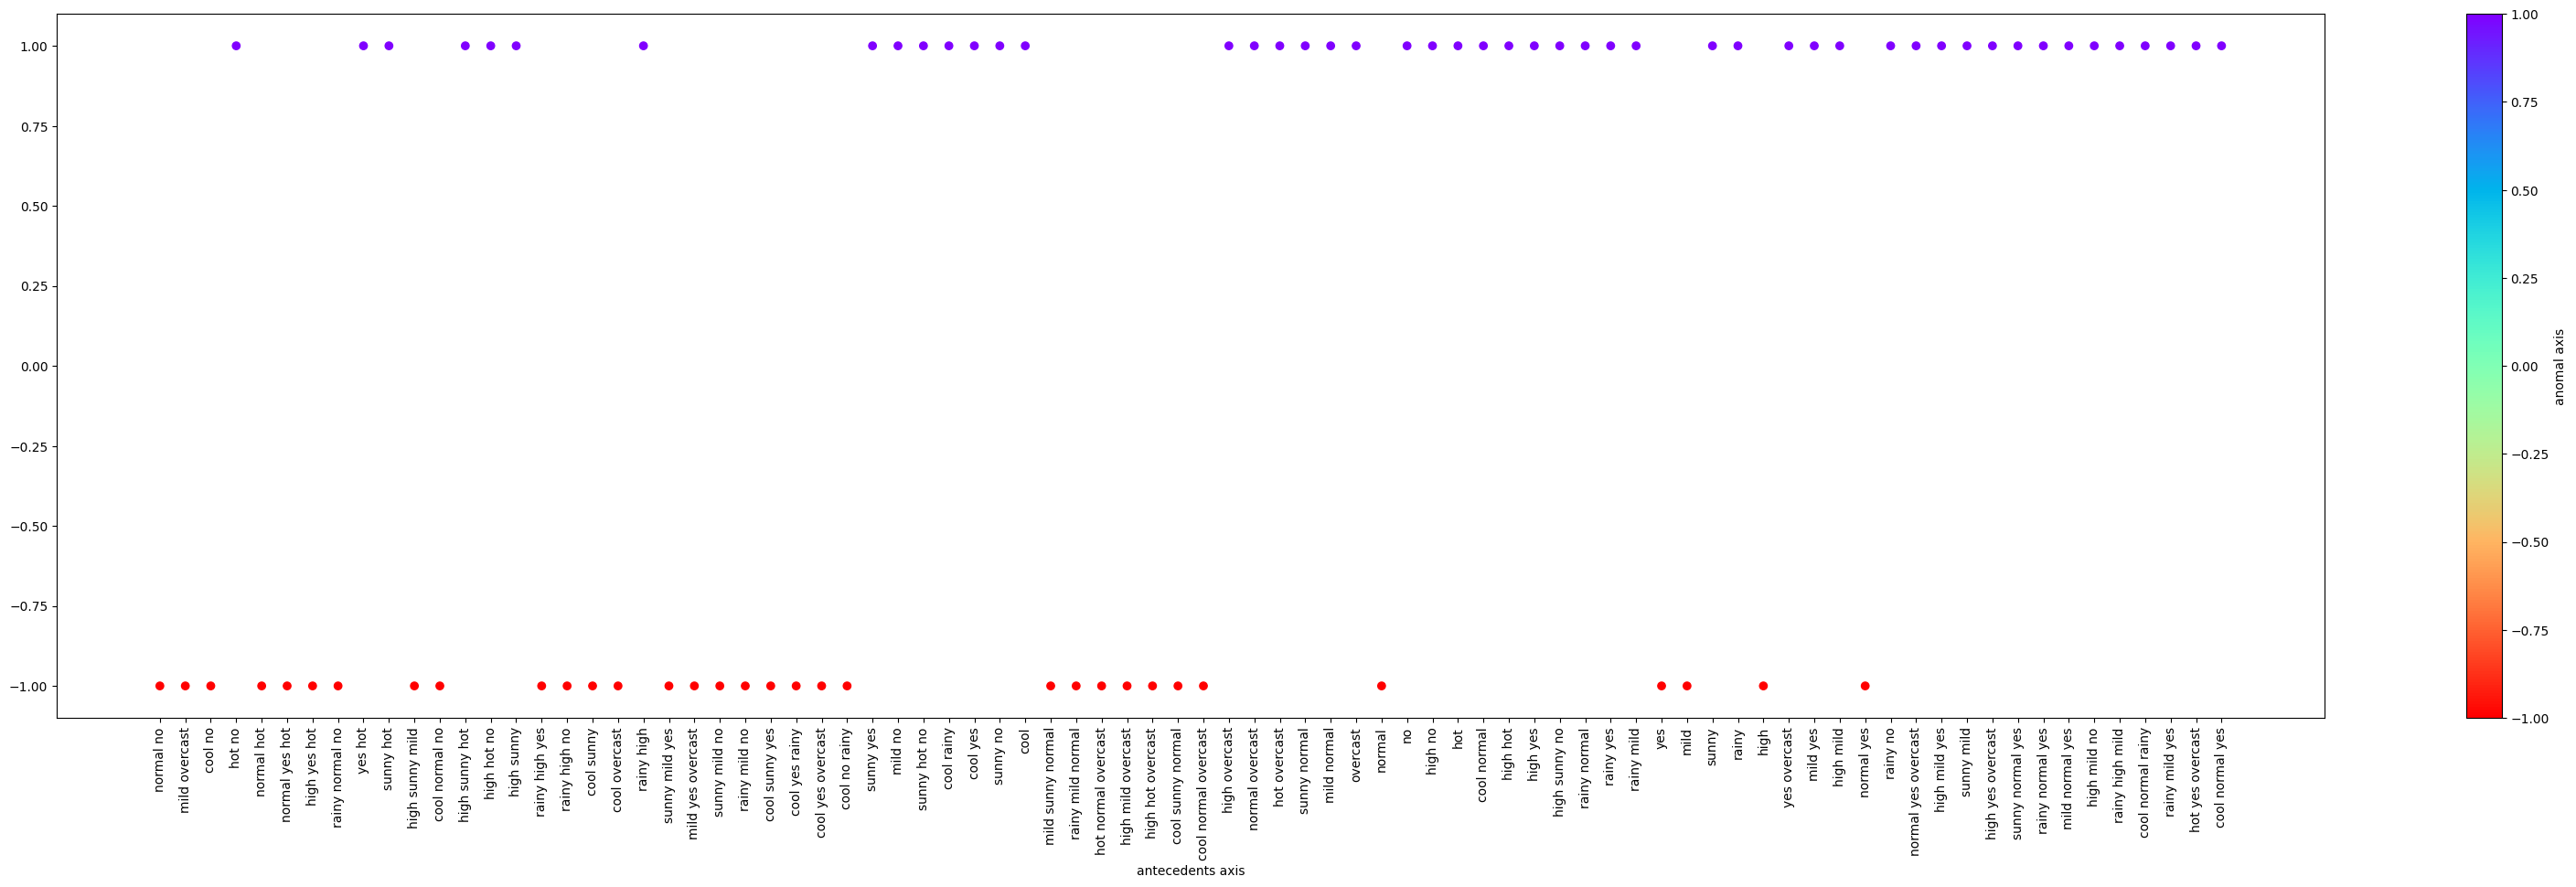

In [65]:
%matplotlib inline
rules2=rules[['antecedents','anomaly']].drop_duplicates()
c = (rules2["anomaly"].values)
fig, ax = plt.subplots(figsize=(40,10))
f = ax.scatter(x=rules2["antecedents"],y=rules2["anomaly"], c=c, cmap='rainbow_r')
cbar = plt.colorbar(f)

ax.set_xlabel('antecedents axis')
ax.set_xticklabels(rules2["antecedents"],rotation=90)
cbar.set_label('anomal axis', rotation=90)